In [3]:
from IPython.display import display, HTML
HTML(
    """
    <script
        src='https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js'>
    </script>
    <script>
        code_show=true;
        function code_toggle() {
        if (code_show){
        $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
        } else {
        $('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
        }
        code_show = !code_show
        }
        $( document ).ready(code_toggle);
    </script>
    <form action='javascript:code_toggle()'>
        <input type="submit" value='Click here to toggle on/off the raw code.'>
    </form>
    """
)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy

import joblib
import random
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

from scipy.spatial.distance import cosine

# Suppress specific RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

<div>
<img src='pics/title2.png' width="100%", max_height="1000">
</div>

<div>
<img src='pics/abstract.png' width="100%", max_height="100">
</div>

This study addresses the limitations of existing anime recommender systems on popular streaming platforms, which often fail to align with user preferences, leading to a reliance on slower, crowdsourced recommendations. With the aim of enhancing user experience and recommendation efficiency, the authors propose the development of a efficient, data-driven recommender system. Utilizing a dataset from Kaggle comprising anime information and user-anime interactions, the research team crafted user-based and item-based collaborative filtering systems, alongside a content-based system focusing on anime synopses. The performance of these systems was evaluated using Mean Absolute Error (MAE) and Normalized Discounted Cumulative Gain (NDCG), demonstrating their effectiveness in providing accurate and relevant recommendations. The findings suggest that the developed systems significantly improve upon the issues found in current recommender systems, offering a promising solution for streaming platforms and hobby communities. This paper highlights the potential of data-driven approaches in overcoming the challenges of anime recommendation, paving the way for future research to further refine and expand upon these methods.

<div>
<img src='pics/problem.png' width="100%", max_height="100">
</div>

Due to the growing dissatisfaction with existing recommender systems for anime on popular streaming platforms, many opt to use crowdsourced recommendations. However, this approach of recommending tends to be rather slow. If a user were to look for a new anime to watch, it would be tedious and time consuming. It drives the question "Can a sophisticated and efficient recommender system be developed?"

<div>
<img src='pics/motivation.png' width="100%", max_height="100">
</div>

Streaming platforms such as Crunchyroll and Netflix have garnered millions of paid subscribers, offering a wide array of content including popular titles like Jujutsu Kaisen among their extensive selection of video content. However, a growing discontent among users regarding the effectiveness of recommender systems has become evident. Users frequently get recommendations for shows they’ve already watched or suggestions that appear incongruent with their preferences. Consequently, many anime enthusiasts would rather refer to third-party websites like [Anilist](https://anilist.co/search/anime) or [MyAnimeList](https://myanimelist.net/) for more reliable anime recommendations. These platforms rely on a crowdsourced model, where users contribute and endorse recommendations for anime titles, fostering a community-driven approach to discovering new content. However, the rapid pace at which new anime are released each season poses significant challenges to the sustainability of such a system, highlighting the need for a more sophisticated, data-driven approach to anime recommendations. This paper aims to explore the development and implementation of a data-driven solution for anime recommendations, addressing the limitations of current recommender systems and enhancing the user experience on streaming platforms and hobby communities. 

<div>
<img src='pics/objectives.png' width="100%", max_height="100">
</div>

The main objective that the team wants to achieve with this study is develop a reliable recommender system that addresses the usual pain points of existing recommender systems in crowd-sourced anime enthusiasts platforms and online anime streaming providers.

The team aims to craft accurate and efficient user-based and item-based collaborative filtering recommender systems, along with a content-based recommender system with performance evaluated using diverse metrics tailored to each system.




<div>
<img src='pics/data_source.png' width="100%", max_height="100">
</div>

The dataset obtained from [Kaggle](https://www.kaggle.com/datasets/dbdmobile/myanimelist-dataset) consists of three primary files: one containing the details of various animes, another containing user information, and a third file documenting user interactions along with their ratings for different animes (Anime Dataset 2023, 2023).
<br><br>
The researchers mainly used the anime information and the user-anime interactions file in this study.





In [3]:
print('Table 1. Anime dataset column names and their associated brief description.')

Table 1. Anime dataset column names and their associated brief description.


| Column       | Description                                                      |
|--------------|------------------------------------------------------------------|
| anime_id     | Unique ID for each anime.                                        |
| Name         | The name of the anime in its original language.                  |
| English name | The English name of the anime.                                   |
| Other name   | Native name or title of the anime (e.g., Japanese, Chinese, Korean).|
| Score        | The score or rating given to the anime. (overall popularity score)                     |
| Genres       | The genres of the anime, separated by commas.                    |
| Synopsis     | A brief description or summary of the anime's plot.              |
| Type         | The type of the anime (e.g., TV series, movie, OVA, etc.).       |
| Episodes     | The number of episodes in the anime.                             |
| Aired        | The dates when the anime was aired.                              |
| Premiered    | The season and year when the anime premiered.                    |
| Status       | The status of the anime (e.g., Finished Airing, Currently Airing, etc.).|
| Producers    | The production companies or producers of the anime.              |
| Licensors    | The licensors of the anime (e.g., streaming platforms).          |
| Studios      | The animation studios that worked on the anime.                  |
| Source       | The source material of the anime (e.g., manga, light novel, original).|
| Duration     | The duration of each episode.                                    |
| Rating       | The age rating of the anime.                                     |
| Rank         | The rank of the anime based on popularity or other criteria.     |
| Popularity   | The popularity rank of the anime.                                |
| Favorites    | The number of times the anime was marked as a favorite by users. |
| Scored By    | The number of users who scored the anime.                        |
| Members      | The number of members who have added the anime to their list on the platform.|
| Image URL    | The URL of the anime's image or poster.                          |


In [4]:
print('Table 2. User-Anime Interaction dataset columns and their brief description.')

Table 2. User-Anime Interaction dataset columns and their brief description.


| Column    | Description                                      |
|-----------|--------------------------------------------------|
| user_id   | Unique ID for each user.                         |
| Username  | The username of the user.                        |
| anime_id  | Unique ID for each anime.                        |
| Anime Title | The title of the anime.                        |
| rating    | The rating given by the user to the anime.      |


The researchers leveraged on these two datasets to create two kinds of recommender systems.
A user-based collaborative filtering recommender systems and a content-based recommender system that used the 'synopsis' as basis of "content".


<div>
<img src='pics/method.png' width="100%", max_height="100">
</div>

## Overview

### Methodology Overview

The team has outlined the following methodology pipeline to ensure alignment with their primary objective:

1. **Data Collection**
    - Gather the dataset containing Anime information and the User-Anime interactions dataset.

2. **Data Wrangling**
    - **Exploratory Data Analysis**: Conduct an initial scan of the dataset to identify duplicated information and empty cells. Additionally, perform preliminary statistical analysis on the dataset.
    - **Data Pre-Processing**: Cleanse the dataset for usability, including dropping or imputing necessary values. Prepare derived datasets to serve as inputs for the recommender systems.

3. **Model Training (Recommender Systems)**
    - **Surprise (Collaborative Filtering) Recommender System**
        - **User-based**: This method examines similar users to a target user and recommends animes liked by those similar users.
        - **Item-based**: This method identifies similar items to unrated animes and suggests animes with similar ratings.
    - **Content-Based Recommender System**: Utilize the "synopsis" of each anime as content. Recommend similar animes based on the vectorized representation of the anime synopses.

4. **Results and Discussion**
    - Evaluate model performance and discuss insights derived from the evaluation.

5. **Conclusion and Recommendations**
    - Provide final thoughts on the study and recommendations for potential improvements in future studies.


## Detailed

### Exploratory Data Analysis

In [5]:
df_anime = pd.read_csv("anime-dataset-2023.csv")
df_user = pd.read_csv("users-score-2023.csv")

During the **Exploratory Data Analysis** phase, the team delved into several key aspects of the dataset to gain insights and ensure its quality. They examined the following:

1. **Missing Values and Duplicates**:



In [6]:
print('Table 3. Number of null values in anime dataset.')

Table 3. Number of null values in anime dataset.


In [7]:
pd.DataFrame(df_anime.isna().sum(), columns=['Number of null values'])

,Number of null values
anime_id,0
Name,0
English name,0
Other name,0
Score,0
Genres,0
Synopsis,0
Type,0
Episodes,0
Aired,0


In [8]:
print('Table 4. Number of null values in user-anime interaction dataset.')

Table 4. Number of null values in user-anime interaction dataset.


In [9]:
pd.DataFrame(df_user.isna().sum(), columns=['Number of null values'])

,Number of null values
user_id,0
Username,0
anime_id,0
Anime Title,0
rating,0


In [10]:
print(f'Number of duplicates in anime dataset: {df_anime.drop("Genres", axis=1).duplicated().sum()}')
print(f'Number of duplicates in user-anime interaction dataset: {df_user.duplicated().sum()}')

Number of duplicates in anime dataset: 0
Number of duplicates in user-anime interaction dataset: 0


The team investigated whether there were any null values within the dataset and identified any duplicated entries as shown in the tables above. Additionally, they assessed if there are specific columns that needed to cleaned -- these can be columns that have values that doesn't make sense.

2. **Global Ratings Distribution**:  

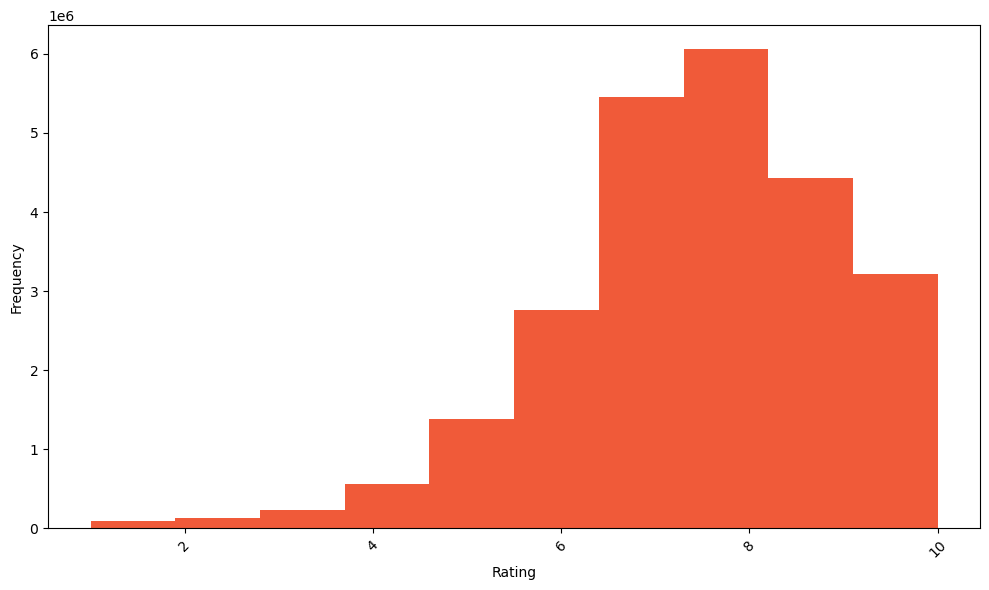

In [108]:
plt.figure(figsize=(10, 6))

df_user.rating.plot(kind='hist', color='#F05A39')
plt.xlabel('Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Figure 1. Global anime rating distribution across users.

They analyzed the frequency distribution of global ratings to understand the overall pattern and variation within the dataset.

In [12]:
print(f'  3. Mean Global Rating: {df_user.rating.mean(): .1f}')

  3. Mean Global Rating:  7.6


 The team calculated the average global rating across all users to gauge the general sentiment towards the anime This allows the team to have a general idea on user rating behaviors.

4. **Top 10 Animes**:

In [109]:
def plot_top_anime(df, n=10):
    """
    Plot the top N anime by average rating and number of votes.
    """
    anime_stats = df.groupby('Anime Title').agg({'rating': ['mean', 'count']})
    anime_stats.columns = ['Average Rating', 'Number of Votes']
    top_anime = anime_stats.sort_values(
        by=['Number of Votes', 'Average Rating'], ascending=False).head(n)
    top_anime_sorted = top_anime.sort_values(
        by='Average Rating', ascending=True)
    plt.figure(figsize=(10, 6))
    top_anime_sorted['Average Rating'].plot(kind='barh', color='#F05A39')
    plt.xlabel('Rating')
    plt.tight_layout()
    plt.show()

    return top_anime_sorted

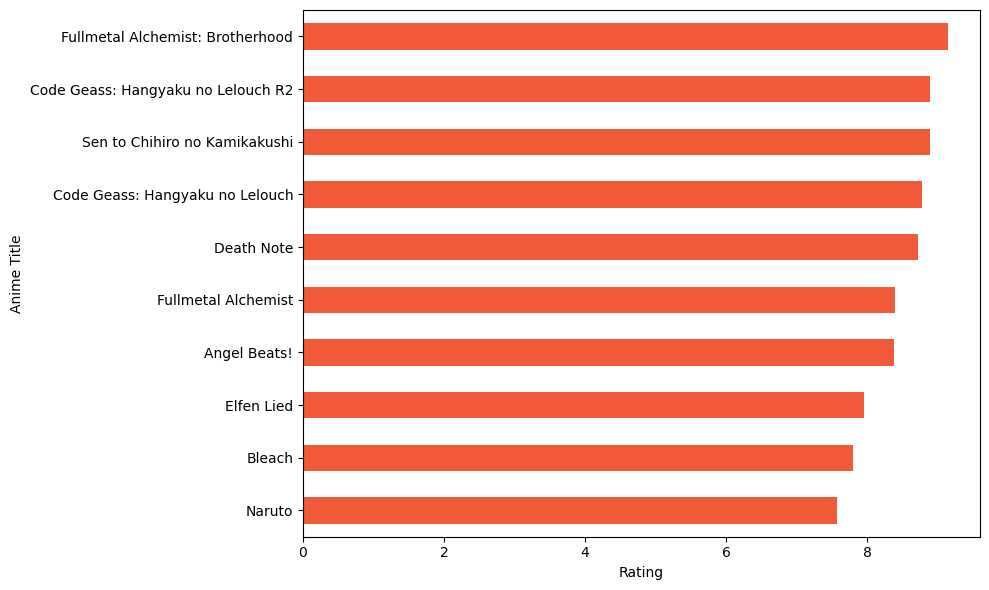

In [110]:
top_anime_sorted_idx = plot_top_anime(df_user, n=10)

Figure 2. Top 10 anime with the highest average rating and number of votes.

They identified the top 10 animes based on various criteria such as by votes and popularity.

In [15]:
df_anime_2 = df_anime.set_index('Name')
top_anime_10_df = df_anime_2.loc[top_anime_sorted_idx.index.tolist()[::-1], [
    'Genres', 'Studios', 'Producers']]
print('Table 5. Top 10 Anime with their genres, studios, and producers.')
top_anime_10_df

Table 5. Top 10 Anime with their genres, studios, and producers.


,Genres,Studios,Producers
Name,,,
Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy",Bones,"Aniplex, Square Enix, Mainichi Broadcasting Sy..."
Code Geass: Hangyaku no Lelouch R2,"Action, Award Winning, Drama, Sci-Fi",Sunrise,"Bandai Visual, Mainichi Broadcasting System, B..."
Sen to Chihiro no Kamikakushi,"Adventure, Award Winning, Supernatural",Studio Ghibli,Toho
Code Geass: Hangyaku no Lelouch,"Action, Award Winning, Drama, Sci-Fi",Sunrise,"Bandai Visual, Mainichi Broadcasting System, B..."
Death Note,"Supernatural, Suspense",Madhouse,"VAP, Konami, Ashi Productions, Nippon Televisi..."
Fullmetal Alchemist,"Action, Adventure, Award Winning, Drama, Fantasy",Bones,"Aniplex, Dentsu, Square Enix, Mainichi Broadca..."
Angel Beats!,"Drama, Supernatural",P.A. Works,"Aniplex, Dentsu, Mainichi Broadcasting System,..."
Elfen Lied,"Action, Drama, Horror, Romance, Supernatural",Arms,"VAP, Genco, Studio Guts"
Bleach,"Action, Adventure, Fantasy",Pierrot,"TV Tokyo, Aniplex, Dentsu, TV Tokyo Music, Stu..."


Furthermore, they examined associated attributes including studios, producers, and genres of these top-rated animes to uncover any patterns or trends.

### Data Pre-processing

In this preprocessing step, the team took action based on the observations derived from the exploratory data analysis.

Firstly, they removed all anime in `df_anime` with blank synopses. By identifying anime IDs without synopses, they filtered out these animes from `df_user` dataframe. Some intances of these datapoints are shown in the table below.

In [16]:
print('Table 6. Snippet of anime dataset with anime with no description.')
df_anime.query("Synopsis=='No description available for this anime.'").head(
    3).drop('Other name', axis=1)

Table 6. Snippet of anime dataset with anime with no description.


,anime_id,Name,English name,Score,Genres,Synopsis,Type,Episodes,Aired,Premiered,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
2412,2626,The☆Doraemons: Mushimushi Pyonpyon Daisakusen!,UNKNOWN,6.35,Fantasy,No description available for this anime.,Movie,1.0,"Mar 7, 1998",UNKNOWN,...,Shin-Ei Animation,Unknown,16 min,PG - Children,7118.0,11312,0,652.0,1583,https://cdn.myanimelist.net/images/anime/11/31...
2413,2628,"The☆Doraemons: Strange, Sweets, Strange?",UNKNOWN,6.11,Fantasy,No description available for this anime.,Movie,1.0,"Mar 6, 1999",UNKNOWN,...,Shin-Ei Animation,Unknown,16 min,PG - Children,8295.0,11634,0,531.0,1405,https://cdn.myanimelist.net/images/anime/1400/...
2414,2629,Doraemon and Itchy the Stray,UNKNOWN,6.48,"Comedy, Sci-Fi",No description available for this anime.,Special,1.0,"Jan 2, 1987",UNKNOWN,...,UNKNOWN,Unknown,22 min,PG - Children,6467.0,10959,1,775.0,1814,https://cdn.myanimelist.net/images/anime/12/57...


In [17]:
df_anime_filtered = df_anime[df_anime['Synopsis']
                             != 'No description available for this anime.']

Due to computational limitations, the researchers decided to limit their working dataset to the top 10,000 users, selected randomly.

One crucial requirement for the content-based recommender system is the utility matrix. This matrix was constructed by creating a table where the indices represent users, the columns represent animes, and the cell values represent ratings. Table 7 shows a snapshot of the utility matrix used. 

In [1]:
def create_util_matrix(df_anime, df_user, sample_size=10000, random_state=42):
    """
    Create a utility matrix from anime and user data.
    """
    anime_idx = df_anime['anime_id'].tolist()
    df_user_content = df_user[df_user['anime_id'].isin(anime_idx)]
    user_idx_content = df_user_content.groupby('user_id').size()
    top_user_idx = user_idx_content.sample(
        sample_size, random_state=random_state).index
    df_rand_user = df_user_content[df_user_content['user_id'].isin(
        top_user_idx)]
    pivot_user = df_rand_user.pivot_table(
        values="rating", index="user_id", columns="anime_id")
    return pivot_user, df_rand_user, user_idx_content

In [57]:
df_utility, df_rand_user, user_idx_content = create_util_matrix(
    df_anime_filtered, df_user, sample_size=10000, random_state=42)
print('Table 7. A snippet of User-Anime Matrix')
df_utility.iloc[:5, :20]

Table 7. A snippet of User-Anime Matrix


anime_id,1,5,6,7,8,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
user_id,,,,,,,,,,,,,,,,,,,,
71,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,8.0,9.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
376,7.0,8.0,9.0,NaN,NaN,NaN,8.0,NaN,NaN,NaN,10.0,10.0,NaN,NaN,8.0,NaN,NaN,7.0,NaN,NaN
380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
429,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,7.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
475,10.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,7.0,8.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
anime_idx = df_utility.columns.to_list()
filtered_anime_df1 = df_anime_filtered[df_anime_filtered['anime_id'].isin(anime_idx)]

Following this, they proceeded to lemmatize and vectorize the synopses into a bag of words using the TFIDF Vectorizer. This vectorization process generated item profiles, which serve as inputs for the content-based recommender system.

In [5]:
# Ensure that NLTK resources are downloaded (do this once)
# nltk.download('wordnet')
# nltk.download('stopwords')

# Lemmatization function
def lemmatize_text(text):
    """Lemmatize the input text"""
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w) for w in word_list])


# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'


def create_tfidf(df_anime, df_utility):
    """Create TF-IDF matrix for anime synopses."""
    filtered_anime_df1['Synopsis'] = filtered_anime_df1['Synopsis'].map(
        lambda text: re.sub('[^a-zA-Z]', ' ', text).lower())
    filtered_anime_df1['Synopsis'] = filtered_anime_df1['Synopsis'].apply(
        lemmatize_text)
    vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'),
                                 min_df=0.01,
                                 max_df=0.95)
    tfidf_matrix = vectorizer.fit_transform(filtered_anime_df1['Synopsis'])
    return pd.DataFrame(tfidf_matrix.toarray(),
                        columns=vectorizer.get_feature_names_out(),
                        index=df_utility.columns)

In [22]:
print('Table 8. Snippet of TF-IDF matrix of anime synopses.')
tfidf_df = create_tfidf(df_anime, df_utility)
tfidf_df.iloc[:5, :20]

Table 8. Snippet of TF-IDF matrix of anime synopses.


,abandoned,ability,able,academy,accident,accidentally,across,act,action,activity,actually,adult,adventure,age,ago,ai,aim,aired,alien,ally
anime_id,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.141130,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.000000,0.0,0.0,0.0,0.166721,0.0,0.172253,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.139239,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.141551,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Regarding the dataset required for the collaborative-filtering recommender systems, the preprocessing step indicated that the `user_score` dataframe was sufficiently clean for training collaborative filtering recommender systems.

### Recommender System Development

The researchers developed two recommender systems using the collaborative filtering method: a user-based and an item-based system, along with one content-based recommender system.

For the collaborative filtering recommender system, which predicts the rating of an unrated anime based on how similar users have rated it or based on how the target user has rated similar animes, the team utilized the `Surprise` Python library. Surprise is designed for building and evaluating recommender systems, providing a simple and efficient framework for collaborative filtering algorithms (Hug, 2020).

The team employed the KNNBasic algorithm from the Surprise package for this study. For both user-based and item-based recommenders, they set the following parameters: min_k = 5 and k = 50. These parameters dictate that the algorithm must find at least 5 similar users before generating recommendations.

In [6]:
def recommend_collab(df_rand_user, user_based=True):
    """Get predictions and model using collaborative filtering."""
    reader = Reader(rating_scale=(1, 10))
    data = Dataset.load_from_df(
        pd.DataFrame(df_rand_user, columns=['user_id', 'anime_id', 'rating']),
        reader)
    trainset, testset = train_test_split(data, test_size=0.25, random_state=26)
    sim_options = {'name': 'pearson', 'user_based': user_based}
    algo = KNNBasic(sim_options=sim_options, k=50, min_k=5, verbose=False)
    algo.fit(trainset)
    predictions = algo.test(testset)
    return predictions, algo

In [24]:
predictions_user, algo_user = recommend_collab(df_rand_user, user_based=True)
predictions_item, algo_item = recommend_collab(df_rand_user, user_based=False)

In [25]:
# Save the trained model to a file
joblib.dump(algo_user, 'collaborative_filtering_model.pkl')
loaded_model = joblib.load('collaborative_filtering_model.pkl')

# Save the trained model to a file
joblib.dump(algo_item, 'collaborative_filtering_model_item.pkl')
loaded_model_item = joblib.load('collaborative_filtering_model_item.pkl')

Regarding the content-based algorithm, the team employed custom code following the algorithm of a content-based recommender system. This involves creating an item profile, generating the user profile of a target user using numeric aggregation, and calculating the cosine distance of the user profile with other unrated animes to return the ones with the closest similarity.

In [7]:
def compute_user_profile_agg_numeric(df_utility, df_item_profiles, user):
    """Compute the user profile using numeric aggregation."""
    user_ratings = df_utility.loc[user]
    mean_rating = user_ratings.mean()
    centered_ratings = user_ratings - mean_rating
    weighted_profiles = df_item_profiles.mul(centered_ratings, axis=0)
    user_profile = weighted_profiles.mean()
    return user_profile

In [8]:
def recommend_agg_numeric(df_utility, df_item_profiles, user_profile, user):
    """Recommend items using aggregated numeric profiles."""
    nan_idx = np.isnan(df_utility.loc[user])
    items = df_item_profiles.loc[nan_idx]
    ratings = sorted(
        [
            (i, cosine(item, user_profile))
            for i, item in items.iterrows()
            if cosine(item, user_profile) > 0
        ],
        key=lambda x: (x[1], x[0]),
    )
    return [i for i, _ in ratings]

In [9]:
def recommended_anime_content(list_id, df_anime):
    """Extract recommended anime content from the given list of IDs."""
    df_anime_reco = pd.DataFrame(columns=df_anime.columns)
    
    for id in list_id:
        row_reco = df_anime[df_anime['anime_id']==id]
        df_anime_reco = pd.concat([df_anime_reco, row_reco], ignore_index=True)
        
    return df_anime_reco

In [31]:
user = 21142
user_profile = compute_user_profile_agg_numeric(df_utility, tfidf_df, user)

<div>
<img src='pics/rnd.png' width="100%", max_height="100">
</div>

In [10]:
def get_reco_cf(df_top_user, user, algo, df_anime):
    """Get collaborative filtering recommendations for a user."""
    user_items = df_top_user[df_top_user['user_id']
                             == user]['anime_id'].tolist()
    all_items = df_top_user['anime_id'].unique()
    not_rated_items = [item for item in all_items if item not in user_items]
    recommendations = [algo.predict(user, item) for item in not_rated_items]
    recommendations.sort(key=lambda x: x.est, reverse=True)
    recommended_items = [pred.iid for pred in recommendations]
    df_anime_reco = pd.DataFrame(columns=df_anime.columns)

    for id in recommended_items:
        row_reco = df_anime[df_anime['anime_id'] == id]
        df_anime_reco = pd.concat([df_anime_reco, row_reco], ignore_index=True)

    return df_anime_reco

In [11]:
def filter_recos(df, n=10):
    """Filter recommended anime based on certain criteria."""
    to_exclude_genres = [
        'Boys Love',
        'Ecchi',
        'Erotica',
        'Girls Love',
        'UNKNOWN'
    ]
    to_exclude_ratings = [
        # 'R - 17+ (violence & profanity)',
        'R+ - Mild Nudity',
        'Rx - Hentai',
        'UNKNOWN']

    to_exclude_type = [
        'Special',
        'Music',
        'UNKNOWN'
    ]
    def should_include(genres_list):
        return not any(genre in to_exclude_genres for genre in genres_list)

    to_exclude_rank = ['0.0', 'UNKNOWN']
    df['Genres'] = df['Genres'].str.split(', ')
    df = df[df['Genres'].apply(should_include)]
    df = df[~df['Rating'].isin(to_exclude_ratings)]
    df = df[~df['Type'].isin(to_exclude_type)]
    df = df[df["Synopsis"] != "No description available for this anime."]
    df = df[~df['Rank'].isin(to_exclude_rank)]
    df = df[df['Popularity']!=0]
    df['Rank'] =  pd.to_numeric(df['Rank'], downcast='integer')
    df = df[~df['Rank']<100]
    return df.head(n)

In [77]:
df_anime_reco_user = get_reco_cf(df_rand_user, user, loaded_model, df_anime)
user_cf_recos = filter_recos(df_anime_reco_user).Name.tolist()

In [79]:
df_anime_reco_item = get_reco_cf(df_rand_user, user, loaded_model_item, df_anime)
item_cf_recos = filter_recos(df_anime_reco_item).Name.tolist()

In [84]:
list_anime = recommend_agg_numeric(df_utility, tfidf_df, user_profile, user)
cb_recos = recommended_anime_content(list_anime, df_anime).Name.tolist()[:10]

In [115]:
anime_rated = df_user.query("user_id==21142")[
    'Anime Title'].tolist() + (['-'] * 3)

To analyze the results, we summarize the anime that `User 21142` watched and rated, along with the top 10 recommendations from User-based CF, Item-based CF, and content-based recommendation systems in the table below.

In [106]:
print('Table 9. Top 10 anime recommendations across all methods.')
pd.DataFrame({
    'Anime Rated': anime_rated,
    'User-based CF': user_cf_recos,
    'Item-based CF': item_cf_recos,
    'Content-based': cb_recos
})

Table 9. Top 10 anime recommendations across all methods.


,Anime Rated,User-based CF,Item-based CF,Content-based
0,Gintama,Gintama',Jungle wa Itsumo Hare nochi Guu Final,DNA²
1,Fullmetal Alchemist,Fullmetal Alchemist: Brotherhood,Tensei shitara Ken deshita,Geneshaft
2,Howl no Ugoku Shiro,Code Geass: Hangyaku no Lelouch R2,Nagi no Asu kara,SoniAni: Super Sonico The Animation
3,Kuragehime,Shouwa Genroku Rakugo Shinjuu: Sukeroku Futata...,Kyoukai no Rinne 3rd Season,Dance with Devils: Fortuna
4,Mawaru Penguindrum,Mushishi Zoku Shou: Suzu no Shizuku,Mayonaka no Occult Koumuin,Aniyome
5,Bleach,Gintama': Enchousen,Zombieland Saga Revenge,B'T X
6,Kuroshitsuji,Ousama Ranking,Kakuriyo no Yadomeshi,Majo Minarai wo Sagashite
7,-,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Ei...,.hack//Liminality,Megami-ryou no Ryoubo-kun.
8,-,Gintama°,.hack//G.U. Returner,Diabolik Lovers
9,-,Ranma ½ OVA,IDOLiSH7,Oniichan wa Oshimai!


1. User-based CF leverages the preferences of similar users to recommend items. It suggested several anime titles based on the preferences of users with similar tastes. Notable recommendations include:

    - Gintama': Given the user's interest in "Gintama," it's reasonable to recommend its sequels and related entries.
    - Fullmetal Alchemist: Brotherhood: A logical recommendation considering the user's enjoyment of "Fullmetal Alchemist."
    - Code Geass: Hangyaku no Lelouch R2: This recommendation aligns with the user's preferences for popular and acclaimed anime series.

2. Item-based CF suggests items similar to those the user has rated highly. It recommended anime with characteristics similar to their previously watched titles. Some of the items that were recommended include:

    - Jungle wa Itsumo Hare nochi Guu Final
    - Tensei shitara Ken deshita
    - Nagi no Asu kara

3. Content-based filtering recommends items based on their content features, specifically synopsis. The algorithm suggested anime with similar characteristics to their previously watched titles. Few recommendations include:

    - DNA²
    - Geneshaft
    - SoniAni: Super Sonico The Animation

Overall, each recommendation method offers unique insights into the user's preferences and introduces diversity, serendipity, and novelty in recommendations:

- User-based CF provides personalized recommendations based on similar user preferences, catering to the user's specific tastes. But, it might overlook niche or less popular titles that could also appeal to the user.
- Item-based CF suggests items similar to the user's highly rated anime, offering a variety of choices within similar content domains. However, item-based CF may overlook diverse preferences and may not introduce the user to new genres or styles.
- Content-based filtering recommends anime based on thematic and stylistic similarities, introducing the user to potentially new but relevant content. It offers recommendations based on the intrinsic features of the items, providing a diverse range of suggestions.

In [12]:
def get_mae_baseline(df_utility):    
    """Calculate the Mean Absolute Error (MAE) for a baseline model."""
    user_count = df_utility.count(axis=1)
    user_at_least_10 = user_count[user_count>=10]
    mae_list = []
    for idx in user_at_least_10.index:
        random.seed(42)
        user_rated = df_utility.loc[idx].dropna()
        random_10_idx = random.sample(user_rated.index.tolist(), 10)
        remove_5_idx = random.sample(random_10_idx, 5)
        ground_truth = user_rated.loc[remove_5_idx]
        naive_ratings = user_rated.loc[random_10_idx]
        naive_ratings.loc[remove_5_idx] = naive_ratings.drop(remove_5_idx).median()
        mae = abs(ground_truth - naive_ratings.loc[remove_5_idx]).mean()
        mae_list.append(mae)
    return pd.Series(mae_list).mean()

In [67]:
mae_baseline = round(get_mae_baseline(df_utility), 2)

### Performance Evaluation

To evaluate the performance of the recommender systems, the team employed specific performance metrics tailored to each approach:

In [66]:
mae_user = round(accuracy.mae(predictions_user, verbose=False), 2)
mae_item = round(accuracy.mae(predictions_item, verbose=False), 2)

**For the collaborative filtering recommender systems:**

The `Surprise` models employed the train_test split method to generate performance metrics. The team focused on optimizing Mean Absolute Error (MAE), as it provides a straightforward understanding of the deviation between actual and predicted rating.

To establish a baseline for comparison, the team calculated the MAE of a list of actual ratings for individual users. They then randomly replaced some ratings with the mean rating of the same user, simulating a naive approach to impute unrated anime. The resulting baseline MAE was  1.20. Table 9. summarizes the MAE for the CF methods used.

In [70]:
print('Table 9. Summary of MAE for Collaborative Filtering and Naive')
display(pd.DataFrame({
    'Model': ['User-based CF', 'Item-based CF', 'Naive'],
    'MAE': [mae_user, mae_item, mae_baseline]
}))

Table 9. Summary of MAE for Collaborative Filtering and Naive


,Model,MAE
0,User-based CF,1.17
1,Item-based CF,1.14
2,Naive,1.20


For this study, the researchers was able to obtain a MAE of  1.17 for User-based CF and  1.14 for Item-based CF. Further contextualizing this value, a deviation of  1.17 or  1.14 rating above or below the expected rating is considered reasonable.

In [13]:
def ndcg_custom(df, rand_user):
    """Calculate Normalized Discounted Cumulative Gain (NDCG) for a given user.
    """
    dcg = 0
    idcg = 0 
    for i, data in df.iterrows():
        idcg += (2**data[rand_user]-1) / (np.log2(i+2))
        dcg += (2**data['score_2']-1) / (np.log2(i+2))
    return dcg/idcg

In [14]:
def get_ndcg_cb(df_utility, tfidf_df, rand_user, seed=42):
    """Compute NDCG for content-based recommendations for a given user."""
    id_with_ratings = df_utility.loc[rand_user].dropna().sort_values(
        ascending=False).index.tolist()
    length_unrated = len(df_utility.loc[rand_user]) - len(
        df_utility.loc[rand_user].dropna())
    random.seed(seed) 
    random_choices = random.sample(id_with_ratings, 15)
    random_ratings = df_utility.loc[rand_user, random_choices].sort_values(
        ascending=False).reset_index()
    ideal = random_ratings.sort_values(by=[rand_user, 'anime_id'],
                                       ascending=[False, True])
    df_utility_2 = df_utility.copy()
    df_utility_2.loc[rand_user, random_choices] = np.nan
    user_profile_2 = compute_user_profile_agg_numeric(df_utility_2, tfidf_df,
                                                      rand_user)
    list_anime_2 = recommend_agg_numeric(df_utility_2, tfidf_df, user_profile_2,
                                         rand_user, length_unrated)
    indices = [
        list_anime_2.index(elem)
        for elem in random_choices
        if elem in list_anime_2
    ]
    zipped_list = list(zip(indices, random_choices))
    rec_rankings = sorted(zipped_list, key=lambda x: x[0])
    ideal['anime_id_2'] = [item[1] for item in rec_rankings]
    # Mapping scores from anime_id to anime_id_2 to create the score_2 column
    score_mapping = ideal.set_index('anime_id')[rand_user].to_dict()
    ideal['score_2'] = ideal['anime_id_2'].map(score_mapping)
    return ideal

In [15]:
def compute_mean_ndcg(user_idx_content, df_utility, tfidf_df):
    """Compute the mean NDCG for a subset of users."""
    user_id = user_idx_content.sort_values(ascending=False)[:1600].index
    users_util = df_utility.index
    fifty_users = [value for value in user_id if value in users_util]
    ndcg_scores = []
    for user in fifty_users:
        df_id_scores = get_ndcg_cb(df_utility, tfidf_df, rand_user=user)
        ndcg = ndcg_custom(df_id_scores, rand_user=user)
        ndcg_scores.append(ndcg)
    return pd.Series(ndcg_scores).mean()

In [62]:
mean_ndcg_cb = compute_mean_ndcg(user_idx_content, df_utility, tfidf_df)

**For the content-based recommender sytem:**

The team utilized the Normalized Discounted Cumulative Gain (NDCG) metric to assess performance. NDCG compares the actual or ideal ranking of animes with the rankings suggested by the recommender system.


The team's model yielded an NDCG score of  0.81. NDCG values range between 0 and 1, with values closer to 1 indicating that the recommendations closely match the ground truth ranking of animes.f animes.f animes. system.

***Interpretation and Implications***

The achieved performance metrics demonstrate the effectiveness of the developed recommender systems in providing accurate and relevant recommendations to users. The comparatively low MAE values and high NDCG score indicate that the collaborative filtering and content-based approaches successfully atains the minimum requirement of a viable recommender system.

<div>
<img src='pics/conclusion.png' width="100%", max_height="100">
</div>

The team successfully developed accurate recommender systems that effectively address prevailing issues observed in existing systems, as evidenced by the achieved MAE and NDCG scores. Capitalizing on the intrinsic characteristics of user-based collaborative filtering, the team ensured recommendations that are novel, diverse, and serendipitous for users. Furthermore, for relevance, both item-based and content-based recommender systems were employed to enhance recommendation precision.

Compared to crowd-sourced recommendation approaches, the team's recommender system stands out for its efficiency in providing quick and comprehensive recommendations.

<div>
<img src='pics/limitation.png' width="100%", max_height="100">
</div

While the study provides valuable insights into recommender system performance, several limitations should be considered:

- Due to resource constraints, the study could not utilize the complete dataset, potentially limiting the comprehensiveness of the findings.

- The content utilized for recommendations relied solely on available synopses of the anime within the dataset. 

<div>
<img src='pics/recommendation.png' width="100%", max_height="100">
</div>

1. Given no computational constraints, the researchers advocate for utilizing the entire dataset to enhance recommendation richness. This broader dataset incorporates more users, thereby increasing the potential for identifying similarities and capturing diverse user behaviors. Additionally, it provides a larger pool of item ratings, further enriching the recommendation process.

2. In content-based approaches, exploring additional features beyond synopses, such as 'Genres', 'Producers', and 'Studios', can lead to the discovery of serendipitous recommendations and enhance recommendation diversity.

3. Exploring user clustering can offer insights into broader trends, enabling the generation of targeted recommendations. Future research could investigate how demographic factors like age, gender, and country of origin influence recommendations.

4. To address the common cold start problem in recommender systems, future studies could focus on designing optimized surveys to initialize user profiles for initial recommendations, thereby improving the system's effectiveness.


<div>
<img src='pics/acknowledgements.png' width="100%", max_height="100">
</div>

The researchers would like to express their heartfelt appreciation to Dr. Christian Alis and Prof. K-Ann Carandang for their consistent support and guidance during the duration the entire Data Mining and Wrangling 2 course, particularly throughout the completion of this project. 

Furthermore, they acknowledge OpenAI's ChatGPT-3.5 and ChatGPT-4 as supplementary tools that aid in the project's execution.

<div>
<img src='pics/appendix.png' width="100%", max_height="100">
</div>

The deployment of the recommendation systems were facilitated using Streamlit (*Please refer to streamlit folder for  the python file*).

Appendix Figure 1. Streamlit application screenshots.

<div>
    <img src='pics/streamlit1.png' width="50%" height="auto" style="max-height: 500px;">
</div>


<div>
    <img src='pics/streamlit2.png' width="50%" height="auto" style="max-height: 500px;">
</div>


<div>
    <img src='pics/streamlit3.png' width="50%" height="auto" style="max-height: 500px;">
</div>


<div>
    <img src='pics/streamlit4.png' width="50%" height="auto" style="max-height: 500px;">
</div>


<div>
<img src='pics/references.png' width="100%", max_height="100">
</div>

 - Anime Dataset 2023. kaggle.com. Retrieved from https://www.kaggle.com/datasets/dbdmobile/myanimelist-dataset
 - Hug, N. (2020). Surprise: A Python library for recommender systems. Journal of Open Source Software, 5(52), 2174. https://doi.org/10.21105/joss.02174